## Load the Data

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle
from utils import TextEmotionDataset

In [18]:
import os
import pickle

# Define the base path relative to the notebook's location
base_path = os.getcwd() 

# Paths to your files
tokenizer_path = os.path.join(base_path, 'tokenizer_csv.pkl')
processed_data_path = os.path.join(base_path, 'processed_data_csv.pkl')
label_encoder_path = os.path.join(base_path, 'label_encoder_csv.pkl')

# Loading the files
# Load the tokenizer
with open(tokenizer_path, 'rb') as file:
    tokenizer = pickle.load(file)

# Load the processed data
with open(processed_data_path, 'rb') as file:
    X_train_pad, X_val_pad, X_test_pad, y_train, y_val, y_test, max_seq_length = pickle.load(file)

# Load the label encoder
with open(label_encoder_path, 'rb') as file:
    label_encoder = pickle.load(file)

# Create datasets and dataloaders for training, validation, and testing
train_dataset = TextEmotionDataset(X_train_pad, y_train)
val_dataset = TextEmotionDataset(X_val_pad, y_val)  # Assuming you have a validation dataset
test_dataset = TextEmotionDataset(X_test_pad, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # Assuming the same batch size as train_loader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Define and Instantiate the CNN Model

In [6]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, n_filters, filter_sizes, drop_prob=0.5):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, n_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_size)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # add channel (1, L, D)
        x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]  # [(N, Co, W), ...]*len(Ks)
        x = [torch.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)
        x = torch.cat(x, 1)
        x = self.dropout(x)
        logit = self.fc(x)
        return logit

# Parameters
vocab_size = len(tokenizer.word_index) + 1
output_size = len(label_encoder.classes_)
embedding_dim = 100
n_filters = 100
filter_sizes = [3, 4, 5]

# Instantiate the model, loss, and optimizer
model = CNNModel(vocab_size, output_size, embedding_dim, n_filters, filter_sizes)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import matplotlib.pyplot as plt

def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=3):
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        correct_train_preds = 0
        total_train_samples = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            total_train_loss += loss.item()

            _, predicted = torch.max(output, 1)
            correct_train_preds += (predicted == labels).sum().item()
            total_train_samples += labels.size(0)

            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train_preds / total_train_samples
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        total_val_loss = 0
        correct_val_preds = 0
        total_val_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                output = model(inputs)
                loss = criterion(output, labels)
                total_val_loss += loss.item()

                _, predicted = torch.max(output, 1)
                correct_val_preds += (predicted == labels).sum().item()
                total_val_samples += labels.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val_preds / total_val_samples
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss} - Val Loss: {avg_val_loss} - Train Acc: {train_accuracy} - Val Acc: {val_accuracy}')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), '/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/saved_models/cnn_te.pth')
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model with early stopping
train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer)

Epoch 1/10 - Train Loss: 1.9029341982603074 - Val Loss: 1.9804010558128358 - Train Acc: 0.3504375 - Val Acc: 0.31921875
Epoch 2/10 - Train Loss: 1.8040894948244095 - Val Loss: 1.9894223409891127 - Train Acc: 0.38846875 - Val Acc: 0.3315625
Epoch 3/10 - Train Loss: 1.6755867941975593 - Val Loss: 2.0372198206186294 - Train Acc: 0.430125 - Val Acc: 0.32796875
Epoch 4/10 - Train Loss: 1.5413152873516083 - Val Loss: 2.1185763770341874 - Train Acc: 0.4754375 - Val Acc: 0.318125
Early stopping triggered


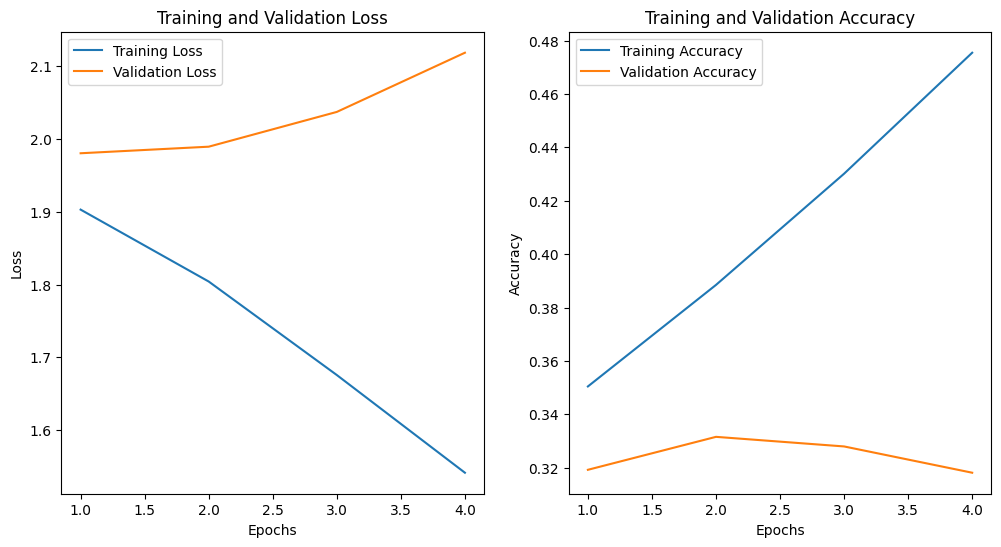

In [11]:
# Plotting
epochs_range = range(1, len(train_losses) + 1)

# Plot for loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            output = model(inputs)
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.numpy())
            true_labels.extend(labels.numpy())
    return classification_report(true_labels, all_preds, target_names=label_encoder.classes_)
    
# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/saved_models/cnn_te.pth'))
report = evaluate_model(model, test_loader)
print(report)


              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         6
     boredom       0.00      0.00      0.00         3
       empty       0.00      0.00      0.00        39
  enthusiasm       0.00      0.00      0.00        37
         fun       0.00      0.00      0.00        75
   happiness       0.31      0.40      0.35       208
        hate       1.00      0.06      0.11        66
        love       0.47      0.41      0.43       153
     neutral       0.31      0.58      0.40       343
      relief       0.00      0.00      0.00        61
     sadness       0.26      0.44      0.32       208
    surprise       0.00      0.00      0.00        81
       worry       0.37      0.22      0.27       320

    accuracy                           0.32      1600
   macro avg       0.21      0.16      0.15      1600
weighted avg       0.30      0.32      0.27      1600



/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and b